In [7]:
! pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.7 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 376 kB 34.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e1a63ea36405760f92722d3b885048990a9865b2d6a13d8dba220fa9109634a4
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0a303dbec0093edb3b24578c1c7762f98078258681d16ea357a14ada734d72cf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [8]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import models, transforms, datasets
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import cv2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ROOT_PATH = '/content/set-lipstick-original/'
IMG_PATH = ROOT_PATH + '/720p'
MSK_PATH = ROOT_PATH + '/mask'
DF_PATH = ROOT_PATH + 'list.csv'
BACKBONE = 'resnet50'

In [4]:
df = pd.read_csv(DF_PATH)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [5]:
len(os.listdir(IMG_PATH)), len(os.listdir(MSK_PATH))

(28594, 28540)

In [6]:
df.shape

(28594, 9)

In [7]:
label_arr = []
for dirname, _, filenames in os.walk(MSK_PATH):
    for filename in filenames:
        label_arr.append(filename)

In [8]:
df.drop(df.loc[~df['mask'].isin(label_arr)].index, inplace=True)

In [9]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # loading data
        self.data = data
        
        # images paths array 
        self.image_arr = self.data['filename']
        
        # masks paths array
        self.label_arr = self.data['mask']
        
        # lenth of pairs
        self.data_len = len(self.data)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # loading images
        img = cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH, self.image_arr[index])), cv2.COLOR_BGR2RGB)       
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # loading masks
        mask = cv2.imread(os.path.join(MSK_PATH, self.label_arr[index]))
        mask = cv2.resize(mask, (256, 256))
        mask = np.asarray(mask).astype('float')           
        mask = torch.as_tensor(mask) / 255.0   
        mask = mask.permute(2,0,1)
            
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


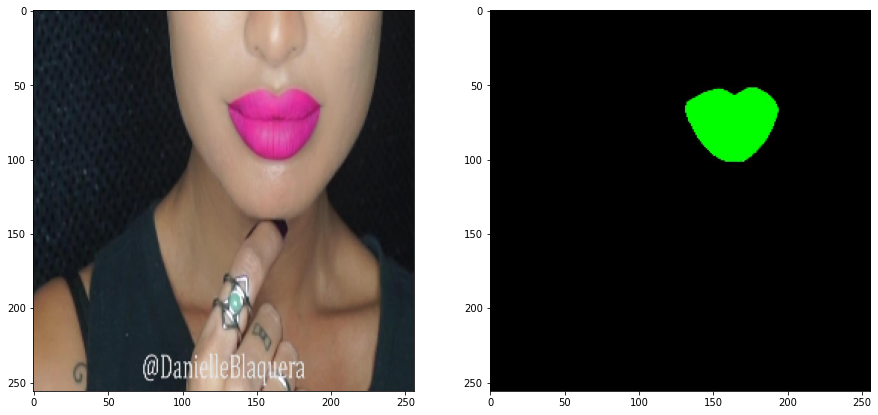

In [11]:
my_dataset = LipsDataset(df)
img, masks = my_dataset[467]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

In [12]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28041,image00028042.jpg,1280,720,Lips,689,333,849,420,mask00028042.png
2826,image00002827.jpg,1280,720,Lips,591,333,679,387,mask00002827.png


In [13]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [14]:
train_dataset = LipsDataset(train_data)

test_dataset = LipsDataset(test_data)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])
tensor(0.) tensor(0.9608)
tensor(0.) tensor(1.)


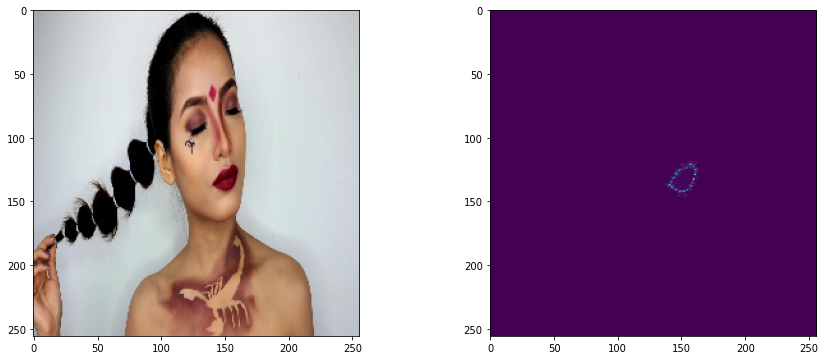

In [15]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [16]:
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


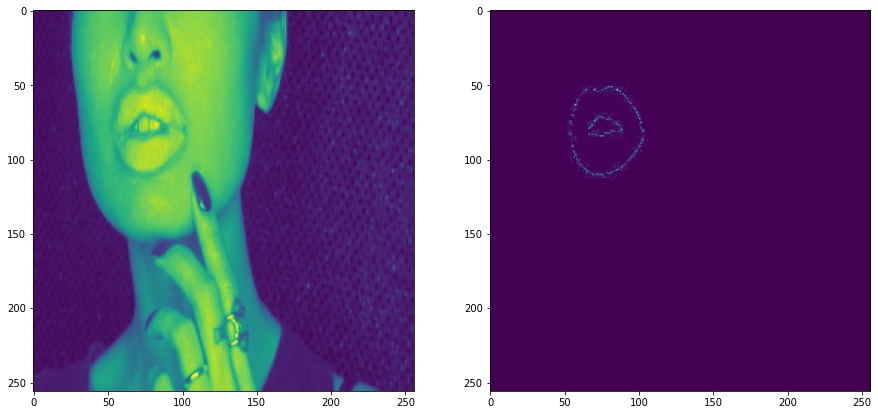

In [17]:
my_dataset_2 = LipsDataset(df, preprocessing=preprocess_input)
img, masks = my_dataset_2[344]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img[0])#.permute(1, 2, 0))
ax[1].imshow(masks[0])#.permute(1, 2, 0))
plt.show()

In [18]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])
tensor(0.0196) tensor(1.)
tensor(0.) tensor(1.)


In [19]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.0001)

In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [21]:
max_score = 0

for i in range(0, 5):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1427/1427 [03:33<00:00,  6.68it/s, dice_loss - 0.03466, iou_score - 0.9432]
Model saved!
Epoch: 2
valid: 100%|██████████| 1427/1427 [03:25<00:00,  6.94it/s, dice_loss - 0.02824, iou_score - 0.9484]
Model saved!
Epoch: 3
valid: 100%|██████████| 1427/1427 [03:27<00:00,  6.89it/s, dice_loss - 0.0261, iou_score - 0.9507]
Model saved!
Epoch: 4
train:   0%|          | 2/2854 [00:01<28:44,  1.65it/s, dice_loss - 0.01545, iou_score - 0.9704]


KeyboardInterrupt: ignored

In [22]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

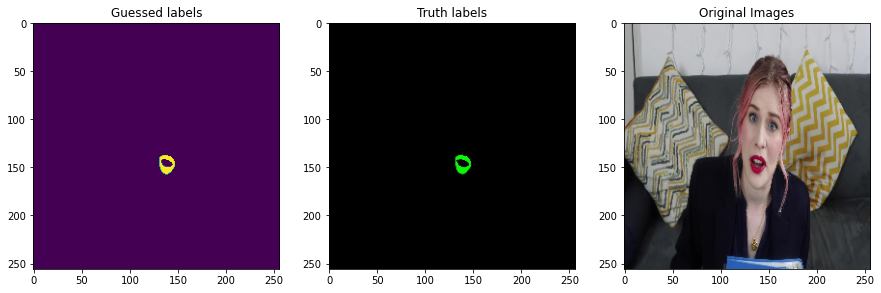

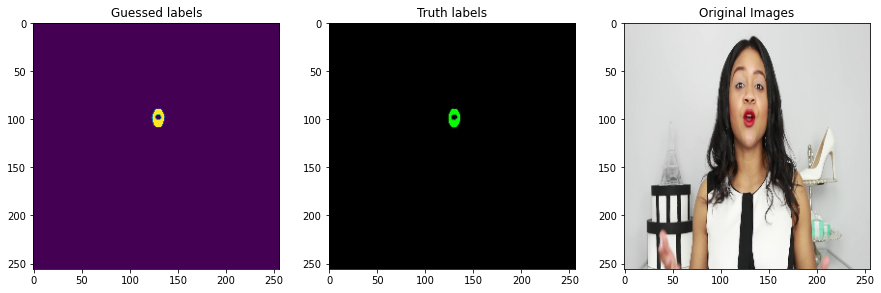

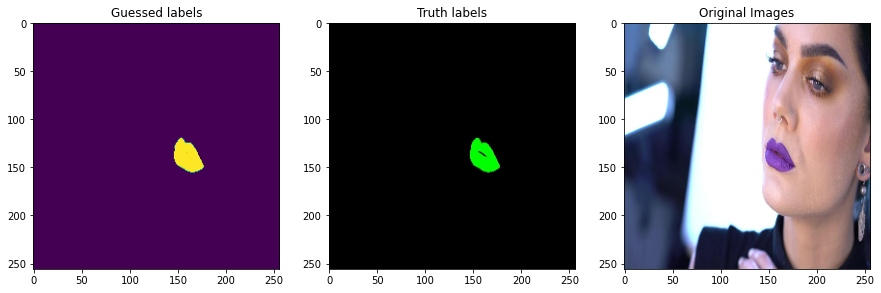

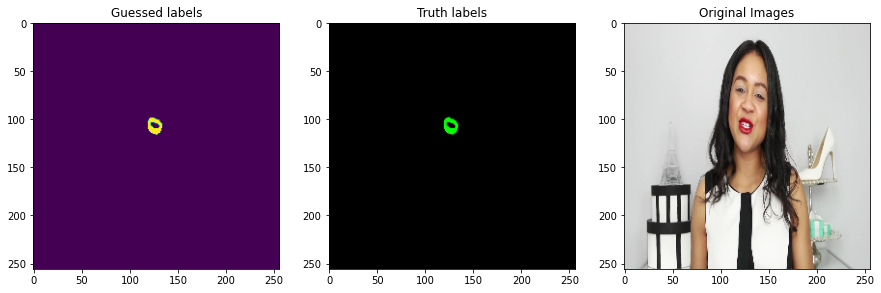

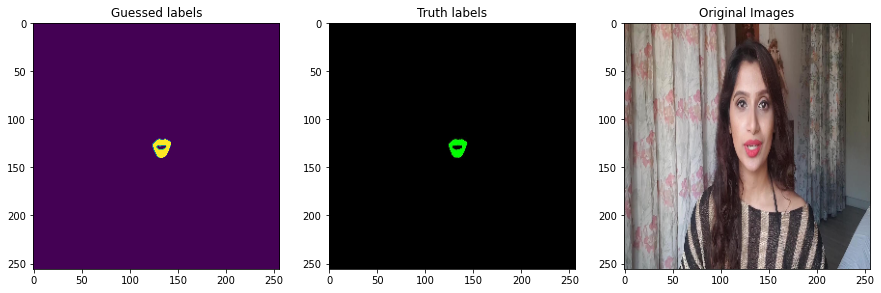

In [23]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    segmodel.eval()
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Guessed labels')
        axarr[1].imshow(labels.squeeze().detach().cpu().numpy()[j,:, :].transpose(1,2,0))
        axarr[1].set_title('Truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 3:
        break